### Importation des librairies

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
plt.style.use('ggplot')
pd.options.display.max_columns = None

# preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# modeles
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
# selection de modeles
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
# métriques d'évaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import warnings
warnings.filterwarnings("ignore")

### Lecture des fichiers

In [57]:
PATH_DATA = "/home/erwan/Bureau/Cas_Ekimetrics/data"

In [58]:
def read_files():
    """Lit les fichiers de train et de test enregistré par le script de feature engineering"""
    path_data = os.path.join(PATH_DATA, 'train_churn.csv')
    
    if not os.path.exists(path_data):
        raise FileNotFoundError("path for train set {} doesn't exist".format(path_train))

    train = pd.read_csv(path_data)
    
    return train

data = read_files()
data.head()

,ID_CONTACT,FIRST_TRANSACTION,LAST_TRANSACTION,DUREE_FIDELE,CHURN,NB_SIGN,SUM_PA,COUNT_PA,STD_PA,SUM_OCC,COUNT_OCC,SUM_EVENT,COUNT_EVENT,NB_MVMNT_NULS,TYPE_CONTACT,TRANCHE_AGE,ADRESSE_POSTALE,EMAIL,TELEPHONE,OPTIN,STOP_TEL,STOP_MAILING,STOP_GENERAL,PA_ACTIF,CYCLE_PA_ACTIF,CANAL_ACQUISITION_AGG,RATIO_OPEN,RATIO_CLICK
0,55,2014-01-10,2017-12-10,46,0,2.0,282.0,47.0,0.0,120.0,1.0,0.0,0.0,0.0,PHYSIQUE,65+,1,1,1.0,1.0,0.0,0.0,0.0,1.0,M,Courrier,0.121495,0.037383
1,112,2014-01-10,2017-12-10,46,0,3.0,376.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,PHYSIQUE,65+,1,1,1.0,0.0,0.0,0.0,0.0,1.0,M,Divers,0.000000,0.000000
2,135,2014-01-10,2017-12-10,46,1,0.0,282.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,PHYSIQUE,65+,1,0,0.0,1.0,0.0,0.0,0.0,0.0,M,Courrier,0.225603,0.018155
3,170,2014-01-10,2017-12-10,46,0,4.0,470.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,PHYSIQUE,65+,1,1,1.0,1.0,0.0,0.0,0.0,1.0,M,Courrier,0.057692,0.000000
4,204,2014-01-10,2017-12-10,46,0,0.0,305.5,47.0,0.0,0.0,0.0,0.0,0.0,0.0,PHYSIQUE,45-65,1,1,1.0,1.0,0.0,0.0,0.0,1.0,M,Divers,0.378947,0.031579


In [59]:
def choose_target(data, target='CHURN'):
    """Choisir entre les target CHURN et PA_ACTIF qui se ressemble fortement"""

    if target == 'CHURN':
        #data = data.drop(['PA_ACTIF'], axis=1)
        y = data.pop('CHURN')
    elif target == 'PA_ACTIF':
        #data = data.drop(['CHURN'], axis=1)
        y = data.pop('PA_ACTIF')
    else:
        raise ValueError("WARNING : vous devez choisir une seule target !")
    
    return data, y

target = 'CHURN'
data, y = choose_target(data, target=target)

### Analyse des données

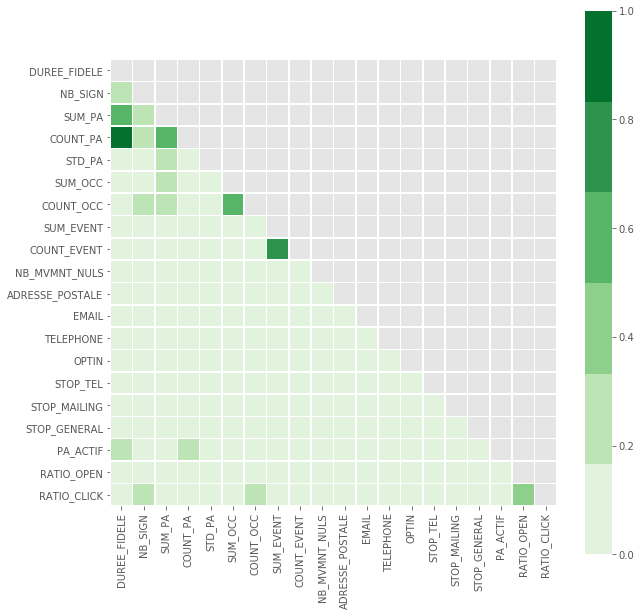

In [60]:
def display_corr(data):
    """Affichage de la matrice de corrélation de data"""
    corr = data.drop(['ID_CONTACT', 'FIRST_TRANSACTION', 'LAST_TRANSACTION'], axis=1).corr().abs()  # calcul de la matrice de covariance
    plt.figure(figsize=(10, 10))
    mask = np.zeros_like(corr, dtype=np.bool) # On génère un masque pour cacher le triangle sup de la matrice
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.color_palette("Greens")
    sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5)
    
display_corr(data)

### Traitement des données

In [61]:
# on split en train et test set
train_data, test_data, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)
print("train size : {}".format(train_data.shape[0]))
print("test size : {}".format(test_data.shape[0]))

train size : 8987
test size : 2247


In [62]:
# on enlève les colonnes inutiles du train set
list_train_contact = train_data.pop('ID_CONTACT')
train_data = train_data.drop(['FIRST_TRANSACTION', 'LAST_TRANSACTION'], axis=1)

# on enlève les colonnes inutiles du test set
list_test_contact = test_data.pop('ID_CONTACT')
test_data = test_data.drop(['FIRST_TRANSACTION', 'LAST_TRANSACTION'], axis=1)

# on rétablit l'index de chaque dataset
train_data.index = range(len(train_data.index))
test_data.index = range(len(test_data.index))

In [63]:
def encode_cat_values(data):
    """Encodage des variables catégoriques"""
    cat_cols = data.select_dtypes(include='object').columns
    for col in cat_cols:
        col_vals = np.array(data[col])  # on récupère les valeurs
        val2enc = col_vals.reshape(len(col_vals), 1)  # on modifie la taille pour passer l'encodeur
        ohe = OneHotEncoder(sparse=False)
        newval = ohe.fit_transform(val2enc)
        name_cols = list(map(lambda x: col + "_" + x, ohe.categories_[0]))  # noms des nouvelles colonnes
        newdf = pd.DataFrame(newval[:,:-1], columns=name_cols[:-1])  # voir (*) en dessous
        data = pd.concat([data.drop([col], axis=1), newdf], axis=1)  # on supprime l'ancienne feature
    return data

train_data = encode_cat_values(train_data)
test_data = encode_cat_values(test_data)

In [64]:
train_data.head()

,DUREE_FIDELE,NB_SIGN,SUM_PA,COUNT_PA,STD_PA,SUM_OCC,COUNT_OCC,SUM_EVENT,COUNT_EVENT,NB_MVMNT_NULS,ADRESSE_POSTALE,EMAIL,TELEPHONE,OPTIN,STOP_TEL,STOP_MAILING,STOP_GENERAL,PA_ACTIF,RATIO_OPEN,RATIO_CLICK,TYPE_CONTACT_MORAL,TRANCHE_AGE_0-25,TRANCHE_AGE_25-45,TRANCHE_AGE_45-65,TRANCHE_AGE_65+,CYCLE_PA_ACTIF_A,CYCLE_PA_ACTIF_M,CYCLE_PA_ACTIF_S,CANAL_ACQUISITION_AGG_Courrier,CANAL_ACQUISITION_AGG_Divers,CANAL_ACQUISITION_AGG_Evenement,CANAL_ACQUISITION_AGG_Mails,CANAL_ACQUISITION_AGG_Street,CANAL_ACQUISITION_AGG_Téléphone,CANAL_ACQUISITION_AGG_Urgence
0,24,0.0,212.0,24.0,1.659404,0.0,0.0,0.0,0.0,0.0,1,1,1.0,1.0,0.0,0.0,0.0,1.0,0.020202,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,13,0.0,150.0,15.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,1.0,1.0,0.0,0.0,0.0,0.0,0.225603,0.018155,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,20,0.0,168.0,21.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,1.0,1.0,0.0,0.0,0.0,1.0,0.058824,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,46,1.0,235.0,47.0,0.000000,32.0,2.0,0.0,0.0,0.0,1,1,1.0,0.0,0.0,0.0,0.0,1.0,1.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,40,0.0,400.0,40.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,1.0,1.0,0.0,0.0,0.0,1.0,0.056075,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [65]:
def scaling(data):
    """Scale les données"""
    col_name = data.columns

    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    data = pd.DataFrame(data, columns=col_name)
    return data

train_data = scaling(train_data)
test_data = scaling(test_data)

### Entrainement de modèles de machine learning

In [31]:
### TEEEST

# Comparaison entre Support Vector Machine, LogisticRegression et XGBoost
RegLog = LogisticRegression()
SVC = SVC()
RandFor = RandomForestClassifier()
XGB = XGBClassifier()

# Cross-validation KFold : 5 partitions indépendantes et aléatoires
kf = KFold(n_splits=5, shuffle=True)

# On fit le modèle sur les différentes partitions et on calcule chaque score
reg_score = cross_val_score(RegLog, train_data, y_train, cv=kf, scoring='roc_auc', n_jobs=-1).mean()
svc_score = cross_val_score(SVC, train_data, y_train, cv=kf, scoring='roc_auc', n_jobs=-1).mean()
rand_score = cross_val_score(RandFor, train_data, y_train, cv=kf, scoring='roc_auc', n_jobs=-1).mean()
xgb_score = cross_val_score(XGB, train_data, y_train, cv=kf, scoring='roc_auc', n_jobs=-1).mean()

# Affichage du score pour chaque modèle
print("AUC Regression Logistique : {}".format(round(reg_score, 4)))
print("AUC SVC : {}".format(round(svc_score, 4)))
print("AUC Random Forest : {}".format(round(rand_score, 4)))
print("AUC XGBoost : {}".format(round(xgb_score, 4)))

AUC Regression Logistique : 0.726
AUC SVC : 0.6586
AUC Random Forest : 0.6543
AUC XGBoost : 0.7328


In [32]:
# Cross-validation KFold en 5 partitions indépendantes et aléatoires
kf = KFold(n_splits=5, shuffle=True)

In [33]:
# Amélioration de la régression logistique

RegLog = LogisticRegression()

param_grid = {
    "C" : [0.001, 0.01, 0.1, 1, 10, 100], 
    "penalty" : ["l1","l2"]
    }

logreg_cv = GridSearchCV(RegLog, param_grid=param_grid, cv=kf, scoring='roc_auc', n_jobs=-1)
logreg_cv.fit(train_data, y_train)
params_opt = logreg_cv.best_params_
score_opt = logreg_cv.best_score_

print("params Regression Logistique optimisés : {}".format(params_opt))
print("score optimisé : {}".format(score_opt))

# params optimisés : {'C': 1, 'penalty': 'l1'}

params Regression Logistique optimisés : {'C': 1, 'penalty': 'l1'}
score optimisé : 0.7253445221082437


In [66]:
# Définition du nouvel estimateur optimisé
try:
    RegLog_opt = LogisticRegression(C=params_opt['C'], penalty=params_opt['penalty'])
except:
    RegLog_opt = LogisticRegression(C=1, penalty='l1')

In [37]:
# Amélioration du SVM

SVC = SVC()

param_grid = {
    'C': [0.1, 1, 10], 
    'gamma' : ['auto'] # [0.01, 0.1, 1],
    #'kernel' : ['linear', 'poly', 'rbf']
}

svm_gs = GridSearchCV(SVC, param_grid=param_grid, cv=kf, scoring='roc_auc', n_jobs=-1)
svm_gs.fit(train_data, y_train)
params_opt = svm_gs.best_params_
score_opt = svm_gs.best_score_

print("params SVM optimisés : {}".format(params_opt))
print("score optimisé : {}".format(score_opt))

# params optimisés : {'C' : 1, 'gamma' : auto}

params SVM optimisés : {'C': 1, 'gamma': 'auto'}
score optimisé : 0.6655761934768053


In [67]:
# Définition du nouvel estimateur optimisé
try:
    SVC_opt = SVC(C=params_opt['C'], gamma=params_opt['gamma'], probability=True)
except:
    SVC_opt = SVC(C=1, gamma='auto', probability=True)

In [41]:
# Amélioration du RandomForest

RandFor = RandomForestClassifier(n_estimators=100)

param_grid = {
    "max_depth": [3, None],
    #"max_features": [1, 3, 10],
    "min_samples_split": [2, 3, 10],
    "criterion": ["gini", "entropy"]
     }

rand_gs = GridSearchCV(RandFor, param_grid=param_grid, cv=kf, scoring='roc_auc', n_jobs=-1)
rand_gs.fit(train_data, y_train)
params_opt = rand_gs.best_params_
score_opt = rand_gs.best_score_

print("params Random Forest optimisés : {}".format(params_opt))
print("score optimisé : {}".format(score_opt))

# params optimisés : {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}

params Random Forest optimisés : {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}
score optimisé : 0.7133950208508925


In [68]:
# Définition du nouvel estimateur optimisé
try:
    RandFor_opt = RandomForestClassifier(n_estimators=100, max_depth=params_opt['max_depth'], 
                                         min_samples_split=params_opt['min_samples_split'],
                                         criterion=params_opt['criterion'])
except:
    RandFor_opt = RandomForestClassifier(n_estimators=100, max_depth=3, min_samples_split=2,
                                        criterion='entropy')

In [43]:
# Amélioration du XGBoost 
    
XGB = XGBClassifier(n_estimators=100)    

param_grid = {
    'max_depth': [4, 5, 8],
    'min_child_weight': [1, 5],
    'gamma': [0.5, 1, 2],
    'subsample': [0.8, 1.0]
    #'colsample_bytree': [0.6, 0.8, 1.0],
    }

xgb_gs = GridSearchCV(XGB, param_grid=param_grid, cv=kf, scoring='roc_auc', n_jobs=-1)
xgb_gs.fit(train_data, y_train)
params_opt = xgb_gs.best_params_
score_opt = xgb_gs.best_score_

print("params XGBoost optimisés : {}".format(params_opt))
print("score optimisé : {}".format(score_opt))

# params optimisés : {'gamma': 2, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.8}

params XGBoost optimisés : {'gamma': 2, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.8}
score optimisé : 0.734187815024967


In [69]:
# Définition du nouvel estimateur optimisé
try:
    XGB_opt = XGBClassifier(n_estimators=100, min_child_weight=params_opt['min_child_weight'], 
                            gamma=params_opt['gamma'], subsample=params_opt['subsample'],
                            max_depth=params_opt['max_depth'])
except:
    XGB_opt = XGBClassifier(n_estimators=100, min_child_weight=1, max_depth=5, subsample=0.8,
                            gamma=2)

In [70]:
# Définition du VotingClassifier
voting = VotingClassifier(estimators=[('rl', RegLog_opt),('svm', SVC_opt),('rf', RandFor_opt), ('xgb', XGB_opt)],
                          voting='soft', weights = [1, 1, 1, 1], n_jobs=-1)
voting.fit(train_data, y_train)

#print("VotingClassifier Score: " + str(voting.score(train_data, train_data)))
#print("VotingClassifier Estimators: " + str(voting_est.estimators_))

VotingClassifier(estimators=[('rl', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('svm', SVC(C=1, ...      reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8))],
         flatten_transform=None, n_jobs=-1, voting='soft',
         weights=[1, 1, 1, 1])

### Prédiction sur l'année suivante

In [71]:
probas = voting.predict_proba(test_data)

In [72]:
probas_churn = list(map(lambda el : el[1], probas))
result_contact = pd.DataFrame({'ID_CONTACT' : list_test_contact, 'PROBA_CHURN' : probas_churn, 'CHURN' : y_test})
result_contact.head()

,ID_CONTACT,PROBA_CHURN,CHURN
1978,450906,0.046816,0
3559,754562,0.070474,0
7866,966689,0.132311,0
1345,206275,0.046731,0
8851,986806,0.098195,0


In [74]:
# Evaluation des résultats pour un seuil fixé

SEUIL = 0.1875
result_contact['PREDICT_CHURN'] = result_contact['PROBA_CHURN'].map(lambda proba : 1 if proba > SEUIL else 0)

auc_score = roc_auc_score(result_contact['CHURN'], result_contact['PREDICT_CHURN'])
prec_score = precision_score(result_contact['CHURN'], result_contact['PREDICT_CHURN'])
rec_score = recall_score(result_contact['CHURN'], result_contact['PREDICT_CHURN'])

print("AUC test set : {}".format(auc_score))
print("Precision test set : {}".format(prec_score))
print("Recall test set : {}".format(rec_score))

AUC test set : 0.8881575549922427
Precision test set : 0.9172259507829977
Recall test set : 0.7976653696498055


In [73]:
# Test du seuil qui maximise l'AUC
list_seuil = np.linspace(0.1, 0.8, 81)
score_opt, seuil_opt = 0, None
for seuil in list_seuil:
    result_contact['PREDICT_CHURN'] = result_contact['PROBA_CHURN'].map(lambda proba : 1 if proba > seuil else 0)
    score = roc_auc_score(result_contact['CHURN'], result_contact['PREDICT_CHURN'])
    if score > score_opt:
        score_opt, seuil_opt = score, seuil
print("Score opt : {}".format(score_opt))
print("Seuil opt : {}".format(seuil_opt))

Score opt : 0.8881575549922427
Seuil opt : 0.1875


In [55]:
result_contact.head()

,ID_CONTACT,PROBA_CHURN,CHURN,PREDICT_CHURN
1978,450906,0.143610,0,0
3559,754562,0.157057,0,0
7866,966689,0.282017,0,0
1345,206275,0.117798,0,0
8851,986806,0.297044,0,0


In [94]:
print(result_contact.shape[0])
print(result_contact.loc[result_contact.PROBA_CHURN > 0.36].shape[0])

16192
7202


Text(0, 0.5, 'Feature Importance Score')

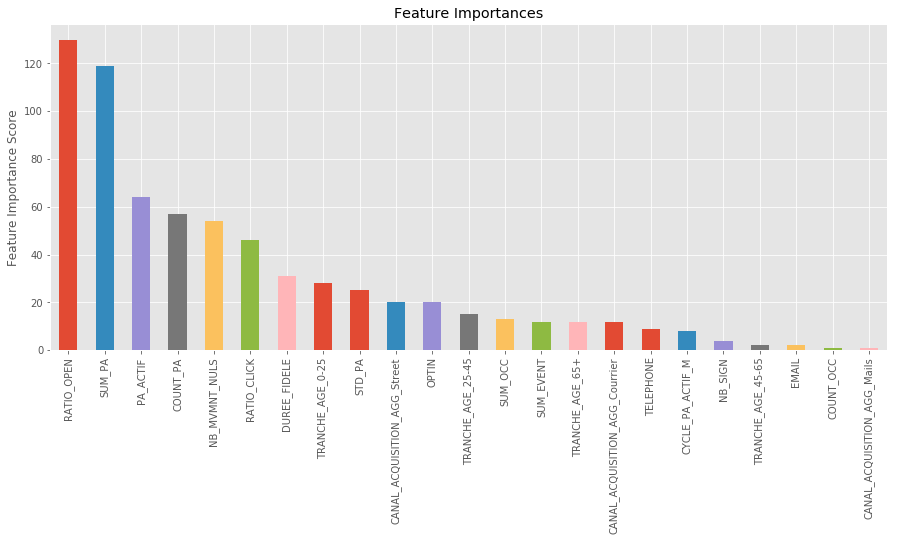

In [75]:
XGB_opt.fit(train_data, y_train)

feat_imp = pd.Series(XGB_opt.get_booster().get_fscore()).sort_values(ascending=False)
plt.figure(figsize=(15, 6))
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')